In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
# NOTE: that using this before my own plt style enable to have right DPI

tfd = tfp.distributions
tfb = tfp.bijectors

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

np.random.seed(42)
tf.random.set_seed(42)

from collections import deque
from datetime import datetime

from ranked_probability_score import ranked_probability_score

2022-06-29 18:34:53.219490: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 18:34:53.219511: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TFP Version 0.16.0
TF  Version 2.9.1


In [2]:
spi = pd.read_csv('../../data/fivethirtyeight/spi_matches.csv')
spi = spi.loc[(spi['league_id'] == 2411)]
spi = spi.loc[(spi['season'] > 2016)]
# spi.isna().any()

In [3]:
step_func = np.ones(600)
step_func[100:200] -= 100/600
step_func[200:300] -= 200/600
step_func[300:400] -= 300/600
step_func[400:500] -= 400/600
step_func[500:] -= 500/600

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from highlight_text import fig_text
mpl.rcParams['figure.dpi'] = 400

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

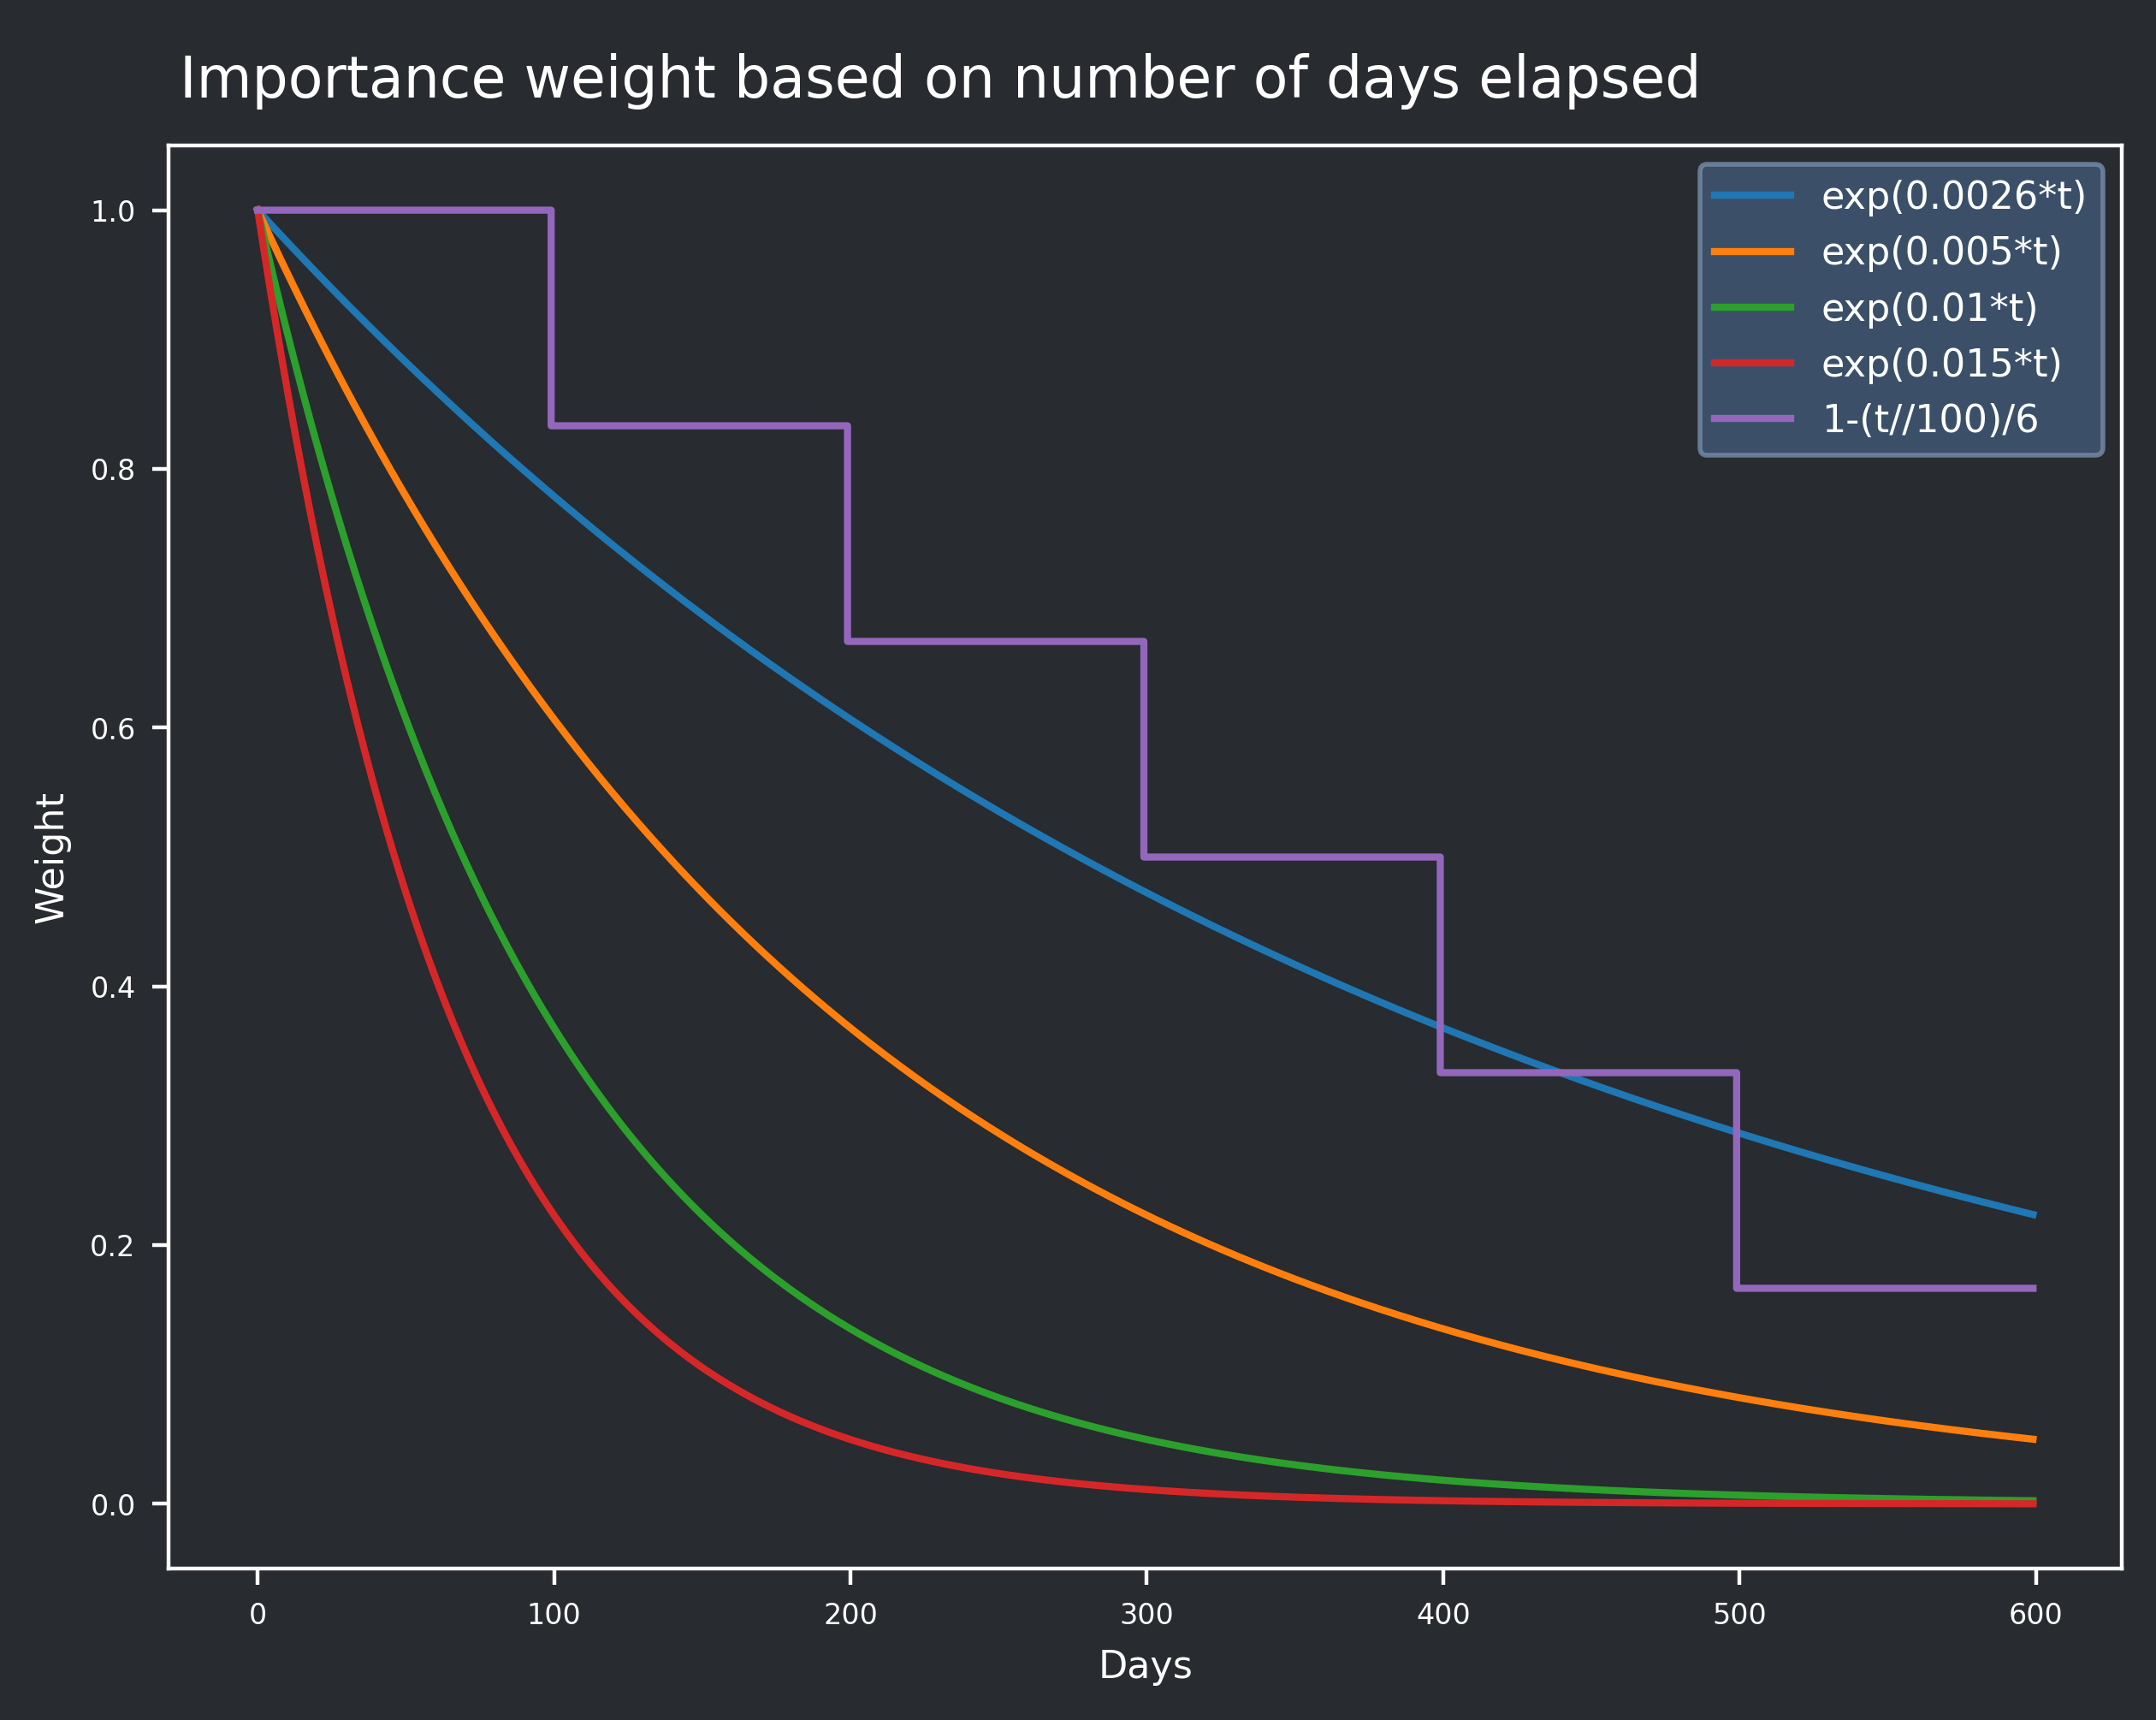

In [5]:
def time_decay(xi, t):
    """ Compute importance weight based on time elapsed

    Args:
        xi (float): Decay rate
        t (int): Days elapsed

    Returns:
        (float): importance weight
    """
    return np.exp(-xi * t)

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

plt.plot(np.arange(600), time_decay(0.0025, np.arange(600)), label='exp(0.0026*t)')
plt.plot(np.arange(600), time_decay(0.005, np.arange(600)), label='exp(0.005*t)')
plt.plot(np.arange(600), time_decay(0.01, np.arange(600)), label='exp(0.01*t)')
plt.plot(np.arange(600), time_decay(0.015, np.arange(600)), label='exp(0.015*t)')

plt.step(np.arange(600), step_func, label='1-(t//100)/6')

ax.set_xlabel('Days', fontsize=8, color=text_color)
ax.set_ylabel('Weight' , fontsize=8, color=text_color)

legend = ax.legend(prop={'size': 8}, frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('#415A77')
frame.set_edgecolor('#778DA9')

fig_text(
    x=0.09, y=1.025,
    s="Importance weight based on number of days elapsed",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

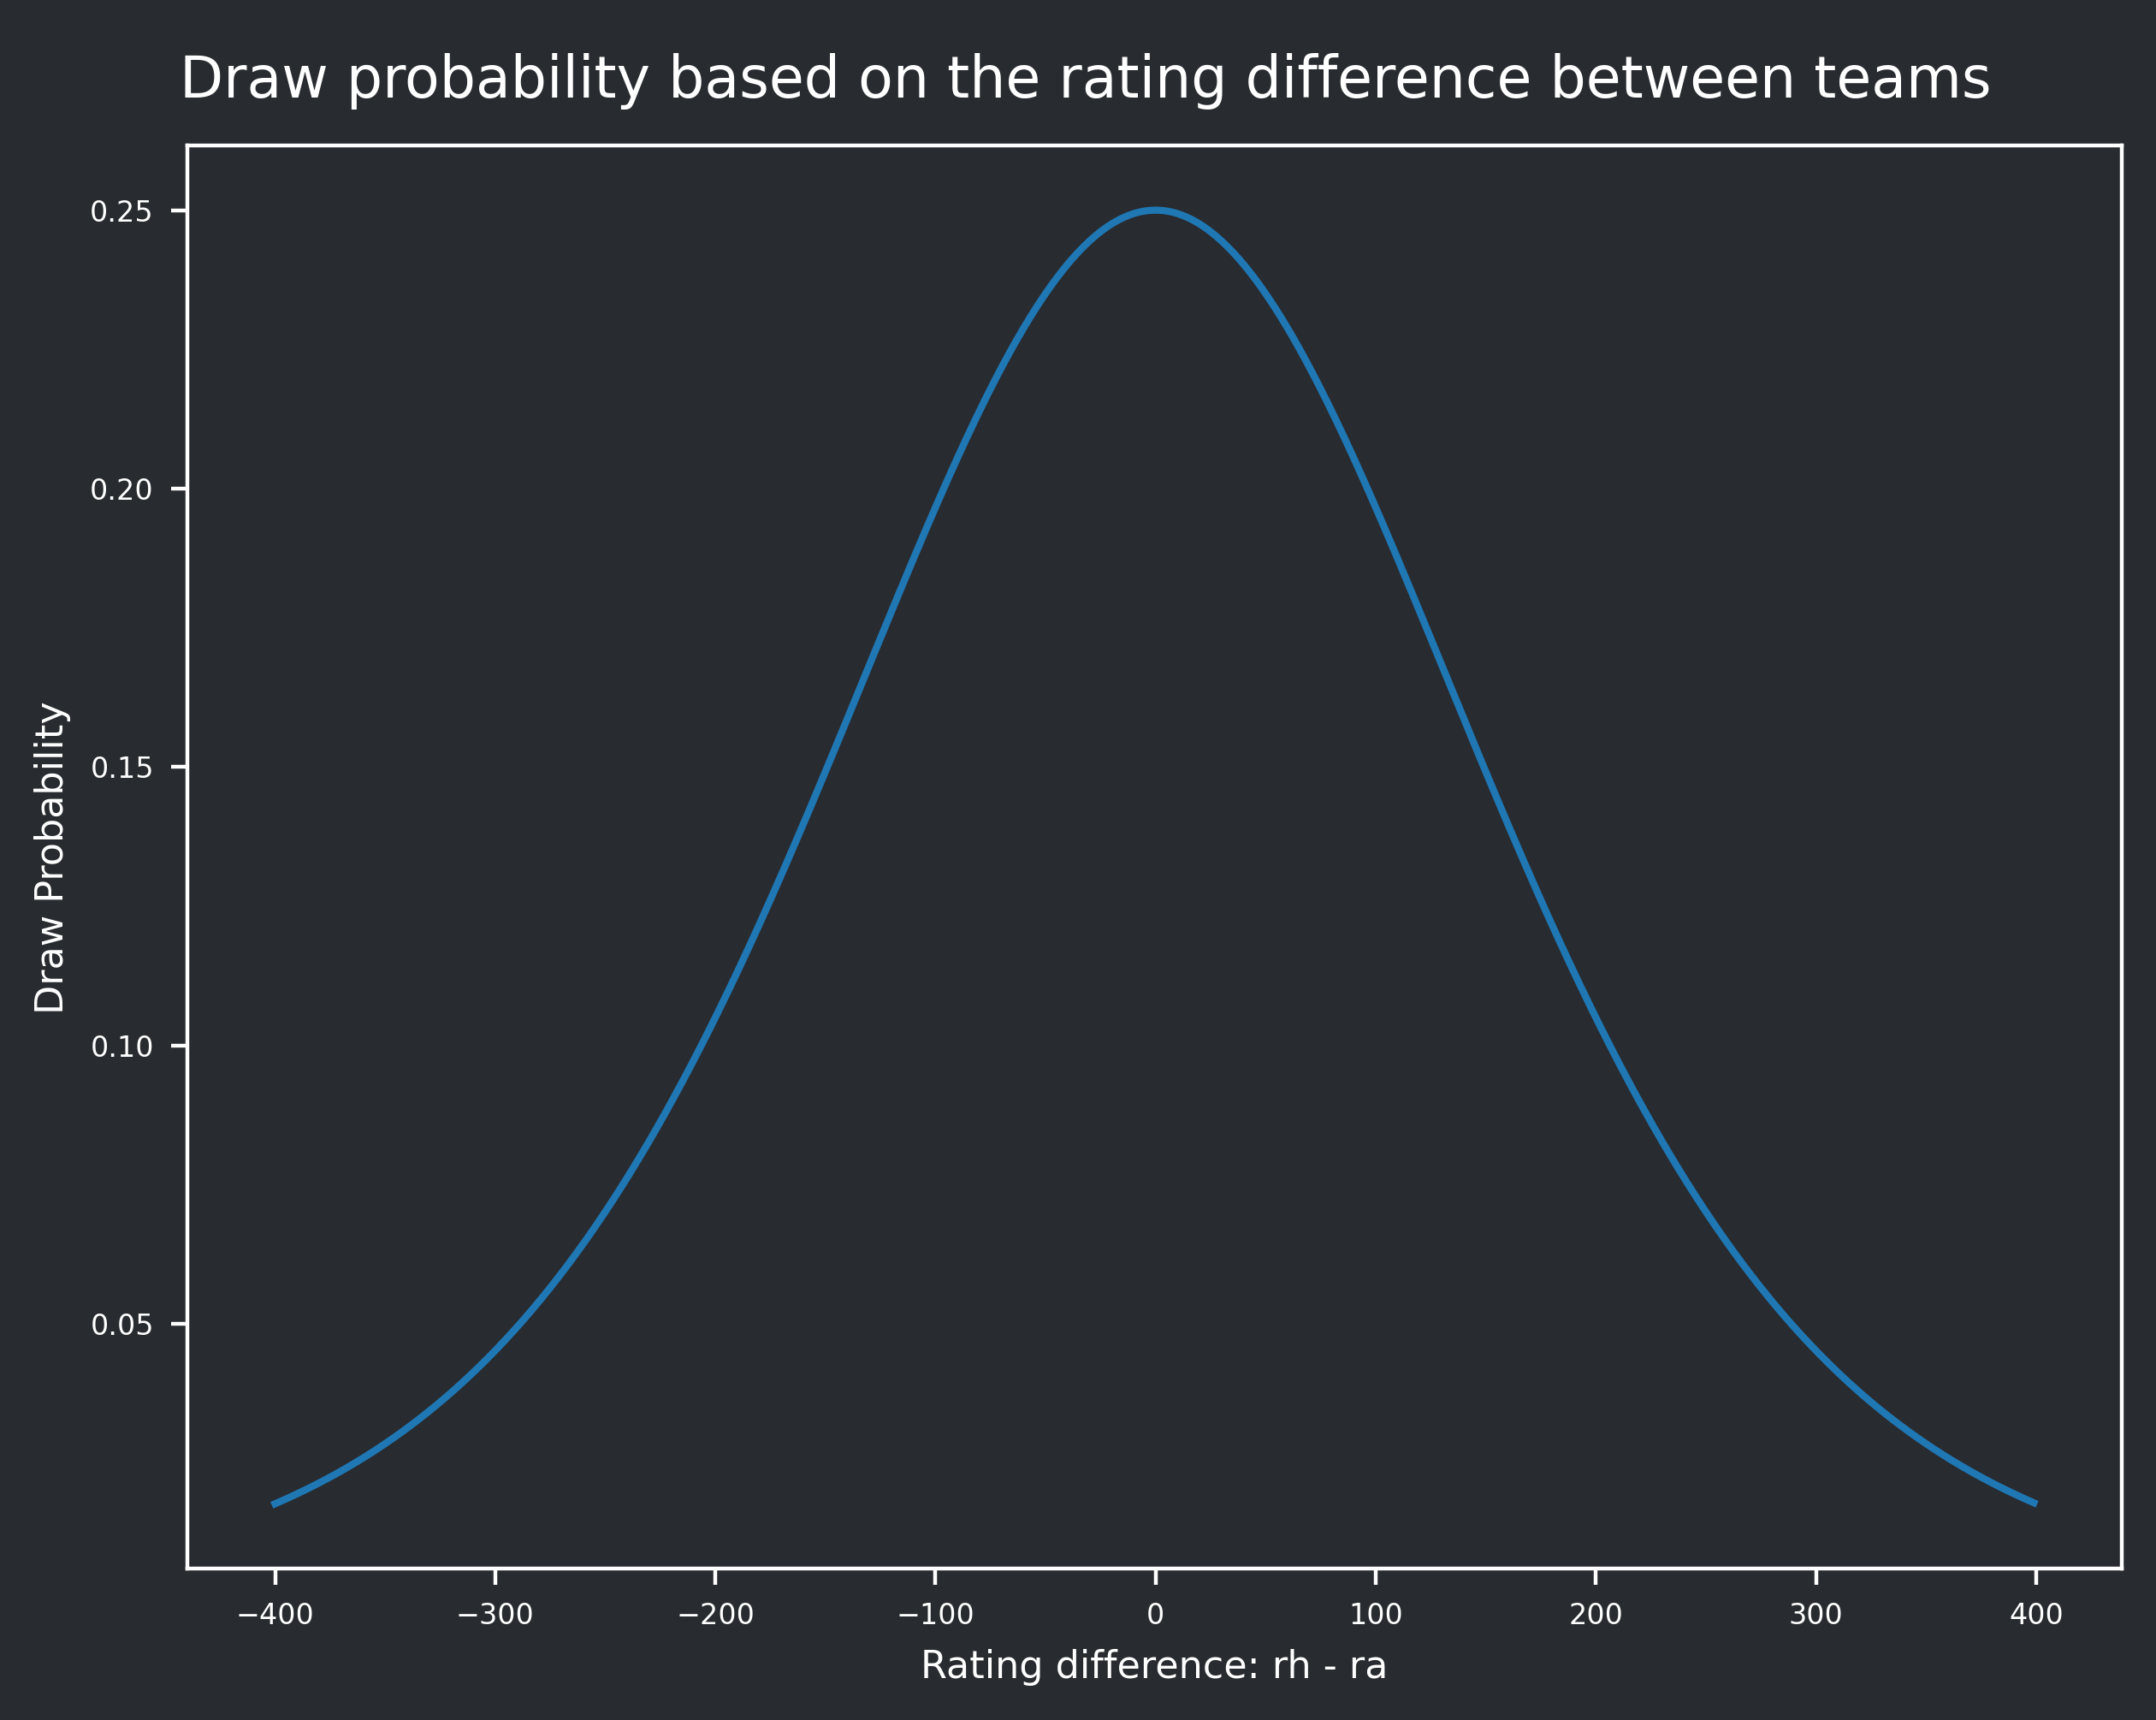

In [6]:
def hubbert(t):
    return np.exp(t / 100) / np.power(1 + np.exp(t / 100), 2)

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

plt.plot(np.arange(800)-400, hubbert(np.arange(800)-400), label='exp(0.015*t)')

ax.set_xlabel('Rating difference: rh - ra', fontsize=8, color=text_color)
ax.set_ylabel('Draw Probability' , fontsize=8, color=text_color)

fig_text(
    x=0.09, y=1.025,
    s="Draw probability based on the rating difference between teams",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

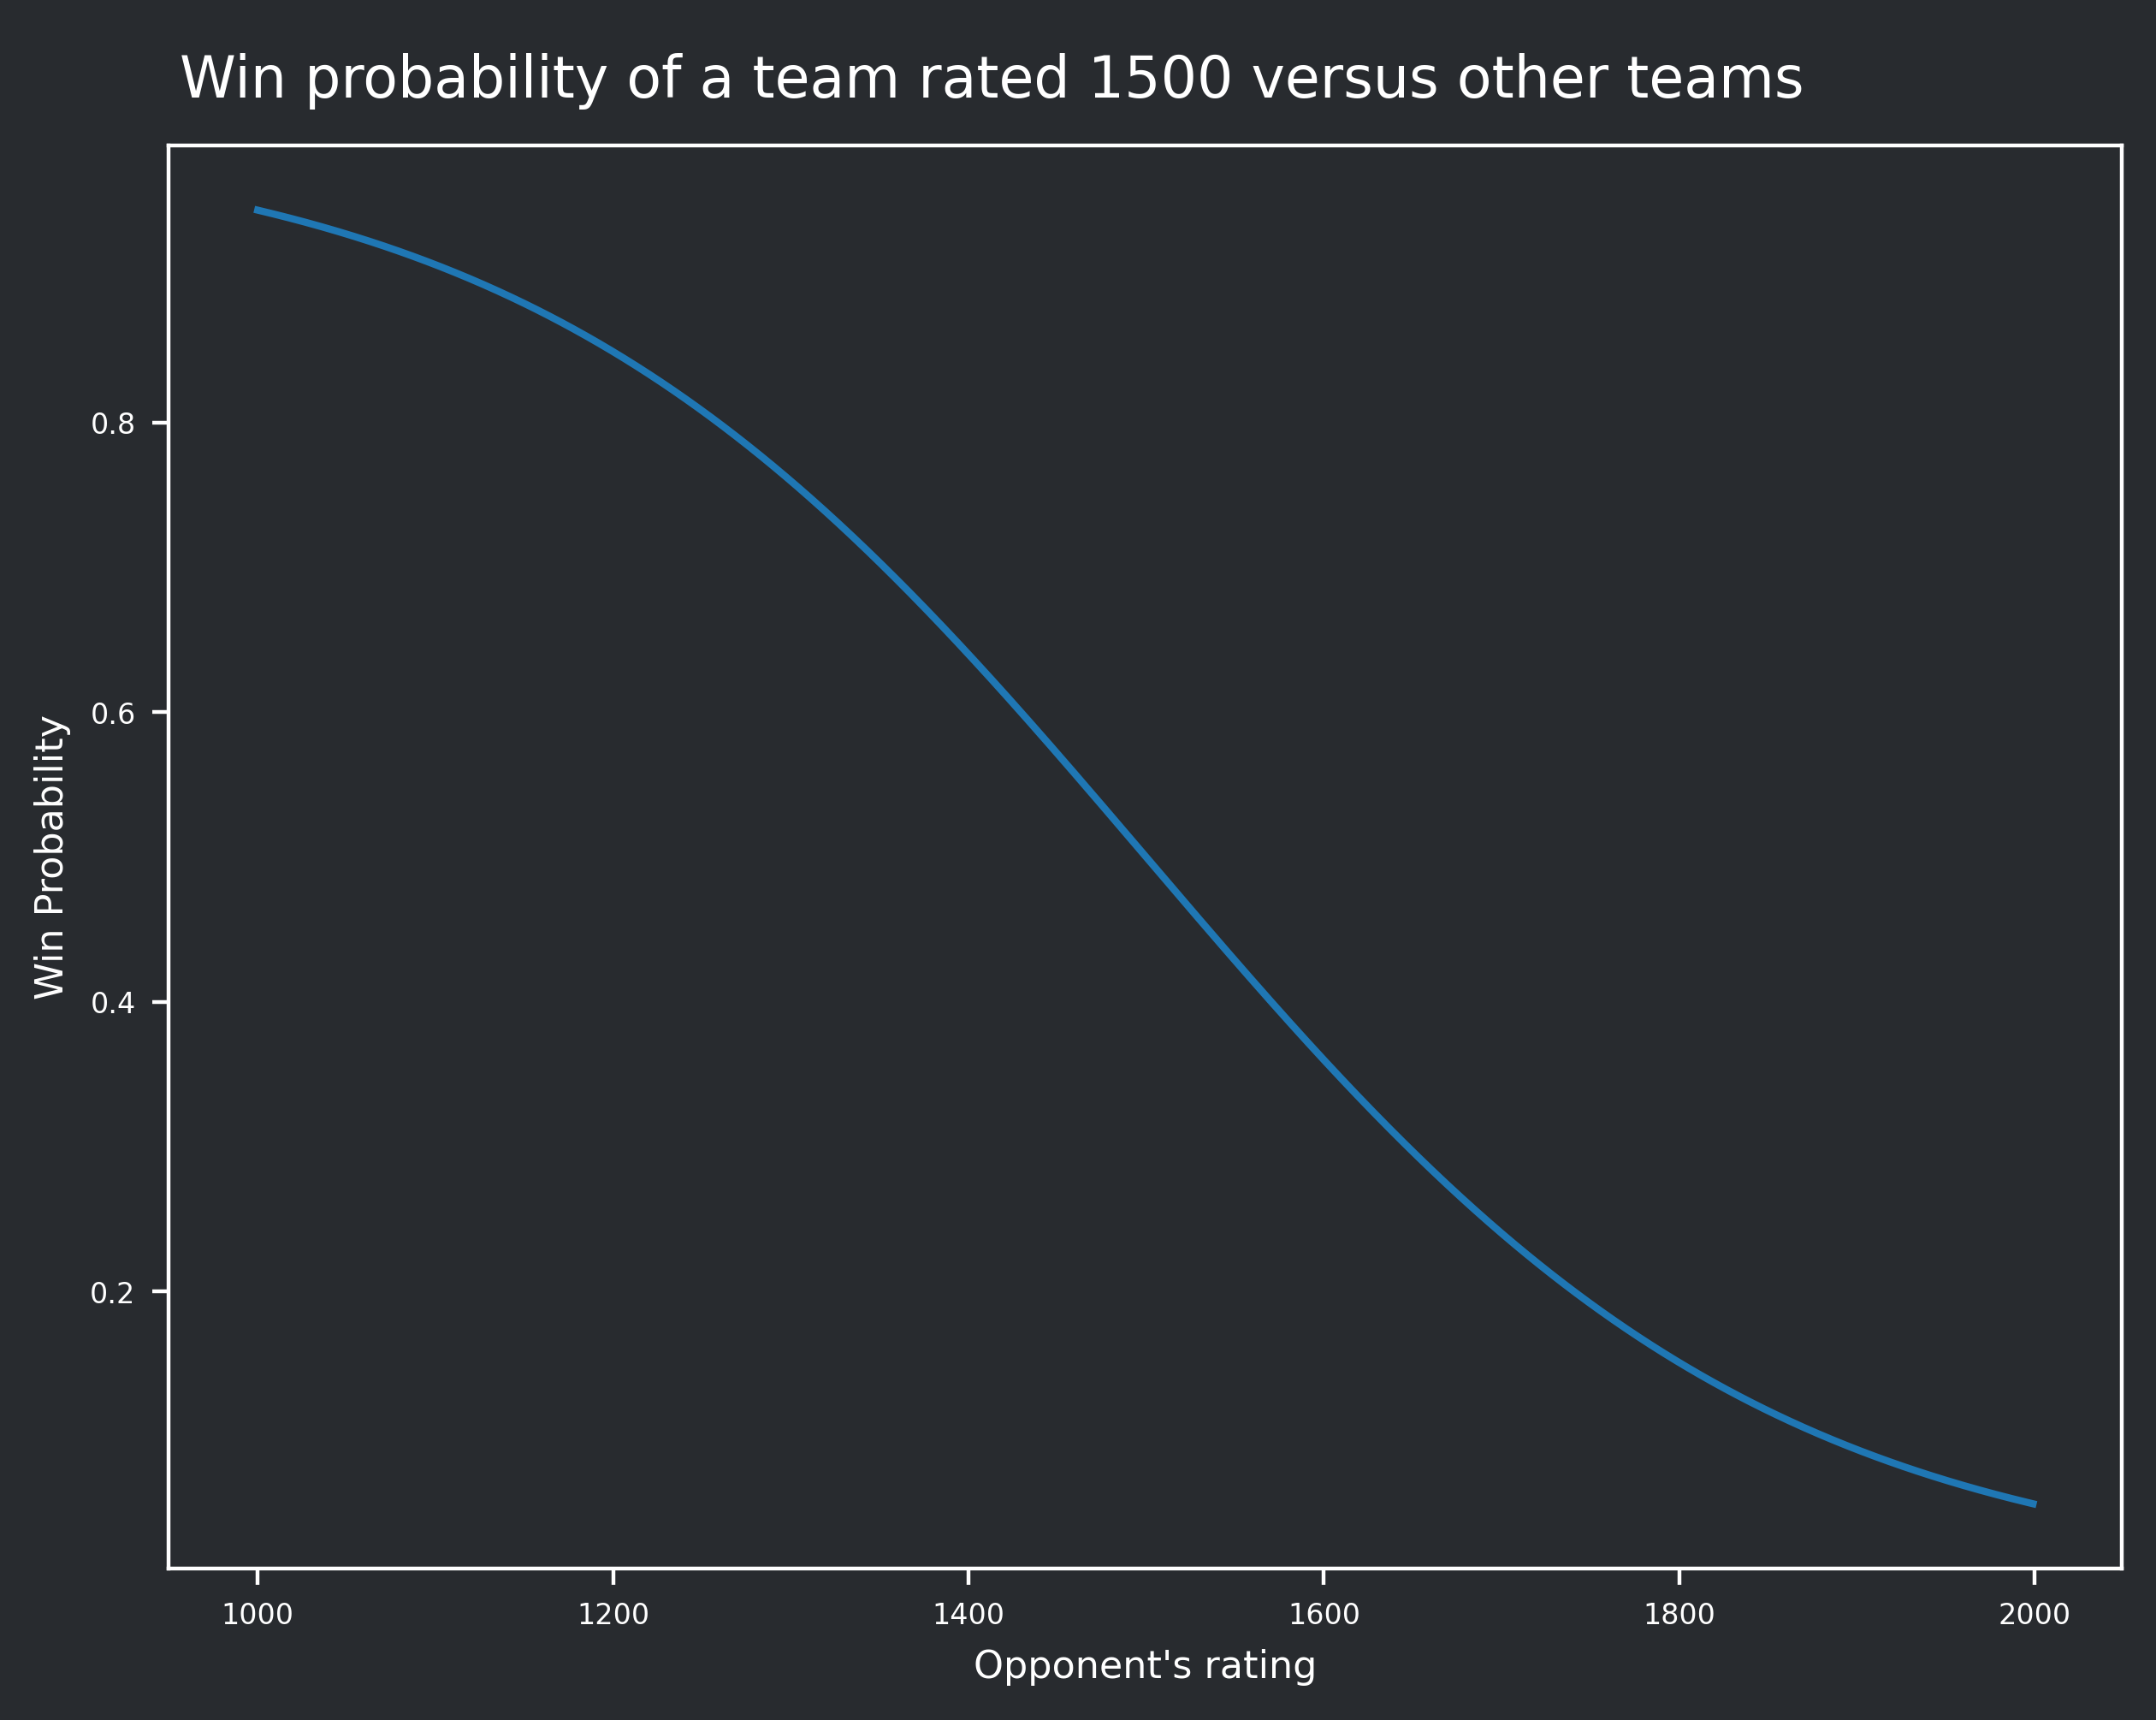

In [7]:
def odds(rating_b, w=400):
    return 1 / (1 + pow(10, (rating_b - 1500) / w))

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

plt.plot(np.arange(1000)+1000, odds(np.arange(1000)+1000))

ax.set_xlabel('Opponent\'s rating', fontsize=8, color=text_color)
ax.set_ylabel('Win Probability' , fontsize=8, color=text_color)

fig_text(
    x=0.09, y=1.025,
    s="Win probability of a team rated 1500 versus other teams",
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)

In [8]:
spi[spi['xg1'].isna()]

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
32166,2019,2020-06-28,2411,Barclays Premier League,Watford,Southampton,72.89,69.38,0.4745,0.262,...,48.4,1.1,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
spi[spi['importance1'].isna()]

,season,date,league_id,league,team1,team2,spi1,spi2,prob1,prob2,...,importance1,importance2,score1,score2,xg1,xg2,nsxg1,nsxg2,adj_score1,adj_score2
36919,2020,2020-11-28,2411,Barclays Premier League,Manchester City,Burnley,93.52,66.74,0.8416,0.0382,...,NaN,NaN,5.0,0.0,2.23,0.40,2.17,0.74,5.25,0.0
37591,2020,2020-12-12,2411,Barclays Premier League,Manchester United,Manchester City,84.18,93.95,0.2507,0.5214,...,NaN,NaN,0.0,0.0,0.63,1.84,0.76,1.12,0.00,0.0
37816,2020,2020-12-17,2411,Barclays Premier League,Aston Villa,Burnley,74.61,65.91,0.5447,0.2089,...,NaN,NaN,0.0,0.0,1.90,0.29,1.86,0.59,0.00,0.0


In [10]:
fbref_fixtures = pd.read_csv("../../data/fbref/fixtures.csv")
fbref_fixtures.head()

,Round,Day,Date,Time,Home,Score,Away,Attendance,Venue,Referee,Notes,Competition
0,1.0,Fri,2021-08-13,20:00,Brentford,2–0,Arsenal,16479.0,Brentford Community Stadium,Michael Oliver,NaN,Premier-League
1,1.0,Sat,2021-08-14,12:30,Manchester Utd,5–1,Leeds United,72732.0,Old Trafford,Paul Tierney,NaN,Premier-League
2,1.0,Sat,2021-08-14,15:00,Leicester City,1–0,Wolves,31983.0,King Power Stadium,Craig Pawson,NaN,Premier-League
3,1.0,Sat,2021-08-14,15:00,Burnley,1–2,Brighton,16910.0,Turf Moor,David Coote,NaN,Premier-League
4,1.0,Sat,2021-08-14,15:00,Chelsea,3–0,Crystal Palace,38965.0,Stamford Bridge,Jonathan Moss,NaN,Premier-League


In [11]:
team_mapping = {
    'Bournemouth': 'AFC Bournemouth',
    'Brighton': 'Brighton and Hove Albion',
    'Huddersfield': 'Huddersfield Town',
    'Leeds': 'Leeds United',
    'Leicester': 'Leicester City',
    'Manchester Utd': 'Manchester United',
    'Newcastle Utd': 'Newcastle',
    'Tottenham': 'Tottenham Hotspur',
    'Sheffield Utd': 'Sheffield United',
    'West Brom': 'West Bromwich Albion',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
}

fbref_fixtures = fbref_fixtures.replace(team_mapping)
fbref_fixtures[~(fbref_fixtures.Date == 'Date')]
fbref_fixtures = fbref_fixtures.sort_values('Date').reset_index(drop=True)

In [12]:
df = pd.merge(
    fbref_fixtures,
    spi,
    left_on=['Date', 'Home', 'Away'],
    right_on=['date', 'team1', 'team2'],
)

assert df.shape[0] == spi.shape[0]

In [13]:
df = df.drop([
       'Day', 'Round', 'Score', 'Competition',
       'Date', 'Time', 'Home', 'Away',
       'Referee', 'Notes', 'league_id', 'league'], axis=1)

df = df.sort_values('date').reset_index(drop=True)

df.Attendance = df.Attendance.astype(np.float64)
df.Attendance = df.Attendance.fillna(0)

teams = np.unique(df.team1)

# df.head()

In [14]:
stadiums = pd.read_csv('../../data/wiki/stadiums.csv')

In [15]:
# Get historical attendance
for team in teams:

    deq_attendance = deque(maxlen=5)
    deq_attendance.append(0.)
    deq_percent_att = deque(maxlen=5)
    deq_percent_att.append(0.)

    for row in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():

        if row[1].team1 == team:
            df.loc[row[0], 'MA_Attendance'] = np.mean(deq_attendance)
            df.loc[row[0], 'MA_Percent_Attendance'] = np.mean(deq_percent_att) #min(np.mean(deq_percent_att), 1)

            capacity = stadiums.loc[stadiums.Stadium == row[1].Venue].Capacity.values[0]
            attendance = row[1].Attendance

            deq_attendance.append(attendance)
            deq_percent_att.append(attendance / capacity)

# df.tail()

In [16]:
# Get historical scores
for team in teams:

    deq_gf = deque(maxlen=5)
    deq_gf.append(0.)
    deq_ga = deque(maxlen=5)
    deq_ga.append(0.)
    deq_gd = deque(maxlen=5)
    deq_gd.append(0.)


    for row in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():
        if row[1].team1 == team:
            suffix = '_h'
        else:
            suffix = '_a'

        df.loc[row[0], 'MA_GF' + suffix] = np.mean(deq_gf)
        df.loc[row[0], 'MA_GA' + suffix] = np.mean(deq_ga)
        df.loc[row[0], 'MA_GD' + suffix] = np.mean(deq_gd)

        deq_gf.append(np.where(row[1].team1 == team, row[1]['score1'], row[1]['score2']))
        deq_ga.append(np.where(row[1].team1 != team, row[1]['score1'], row[1]['score2']))
        deq_gd.append(
            np.where(
                row[1].team1 == team,
                row[1]['score1'] - row[1]['score2'],
                row[1]['score2'] - row[1]['score1']))

# df.tail()

In [17]:
# Get time elapsed between games
for team in teams:

    for row in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():
        if row[1].team1 == team:
            suffix = '_h'
        else:
            suffix = '_a'

        fix = fbref_fixtures[
            (fbref_fixtures.Home.str.contains(team)) |
            (fbref_fixtures.Away.str.contains(team))
            ]
        fix = fix.sort_values('Date').reset_index(drop=True)
        fix = fix.loc[fix.Date < row[1].date]

        if fix.shape[0] == 0:
            df.loc[row[0], 'time_since_last_game' + suffix] = 60

        else:
            d1 = datetime.strptime(fix.Date.values[-1], "%Y-%m-%d")
            d2 = datetime.strptime(row[1].date, "%Y-%m-%d")

            df.loc[row[0], 'time_since_last_game' + suffix] = abs((d2 - d1).days)

# df.tail()

In [18]:
# Get streak
for team in teams:

    deq_streak = deque(maxlen=5)
    deq_streak.append(0.)

    for row in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():
        if row[1].team1 == team:
            suffix = '_h'
            pts = 3 if row[1].score1 > row[1].score2 else( 1 if row[1].score1 == row[1].score2 else 0 )
        else:
            suffix = '_a'
            pts = 3 if row[1].score1 < row[1].score2 else( 1 if row[1].score1 == row[1].score2 else 0 )

        df.loc[row[0], 'Streak' + suffix] = np.mean(deq_streak) / 3
        # df.loc[row[0], 'Weighted_Streak' + suffix] = np.mean(
        #     deq_streak *
        #     np.sum(np.array([0.1, 0.15, 0.2, 0.25, 0.3]))
        #     )

        deq_streak.append(pts)

# df.tail()

In [19]:
# Get Elo rating
from elo import Elo

elo_df = (
    pd.read_csv(
        f'https://www.football-data.co.uk/mmz4281/{season}/E0.csv',
        usecols=['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'],
        encoding='unicode_escape')
    for season in [
        # '9394', '9495', '9596', '9697', '9798',
        # '9899', '9900', '0001', '0102', '0203',
        # '0304', '0405', '0506', '0607', '0708',
        '0809', '0910', '1011', '1112', '1213',
        '1314', '1415', '1516', '1617',
        '1718', '1819', '1920', '2021', '2122'])

elo_df = (
    pd.concat(elo_df)
    .rename(columns={
        "HomeTeam": "team1",
        "AwayTeam": "team2",
        "FTHG": "score1",
        "FTAG": "score2",
        "Date": "date",
        })
    .dropna())

# Train model on all games up to the previous GW
model = Elo(elo_df)
model.fit()

# Normalize names to merge
team_mapping['Cardiff'] = 'Cardiff City'
team_mapping['Man City'] = 'Manchester City'
team_mapping['Man United'] = 'Manchester United'
team_mapping['Norwich'] = 'Norwich City'
team_mapping['Stoke'] = 'Stoke City'
team_mapping['Swansea'] = 'Swansea City'

model.historical_rating = model.historical_rating.replace(team_mapping)

# Merge with rest of data
model.historical_rating.date = pd.to_datetime(model.historical_rating.date).dt.date
df.date = pd.to_datetime(df.date).dt.date

shape_flag = df.shape[0]

df = pd.merge(
    model.historical_rating,
    df,
    left_on=['date', 'team1', 'team2'],
    right_on=['date', 'team1', 'team2'],
)

assert df.shape[0] == shape_flag

df = df.rename(columns={
    "rating1": "elo1",
    "rating2": "elo2",
    })

In [20]:
# Get Seasonal form
current_season = np.min(df.season)-1
gamma = 0.33

for index, match in df.iterrows():
    # Get match data
    home_team = match['team1']
    away_team = match['team2']

    if match['season'] != current_season:
        current_season = match['season']
        # Reset ratings
        team_ratings = (
            df.loc[:, ["team1"]]
            .drop_duplicates()
            .sort_values("team1")
            .reset_index(drop=True)
            .assign(team_index=np.arange(len(np.unique(df["team1"]))))
            .assign(form=1)
            .rename(columns={"team1": "team"})
        )

    home_rating = team_ratings.loc[
        team_ratings.team == home_team]['form'].values[0]
    away_rating = team_ratings.loc[
        team_ratings.team == away_team]['form'].values[0]

    # Save the rating prior to the game
    df.loc[
        index,
        'form1'] = home_rating
    df.loc[
        index,
        'form2'] = away_rating

    # Update ratings
    team_ratings.loc[
        team_ratings.team == home_team, 'form'] = (
            home_rating + gamma * away_rating if match['score1'] > match['score2']
            else home_rating - gamma * home_rating if match['score1'] < match['score2']
            else home_rating - gamma * (home_rating - away_rating)
        )

    team_ratings.loc[
        team_ratings.team == away_team, 'form'] = (
            away_rating + gamma * home_rating if match['score2'] > match['score1']
            else away_rating - gamma * away_rating if match['score2'] < match['score1']
            else away_rating - gamma * (away_rating - home_rating)
        )

In [21]:
# Get Season completion
current_season = np.min(df.season) - 1
current_date = 0
games_played = 0
gw_games = 0

for index, match in df.iterrows():

    # Reset for new seasons
    if match['season'] != current_season:
        current_season = match['season']
        current_date = match['date']
        games_played = 0
        gw_games = 0

    if current_date == match['date']:
        gw_games += 1

    else:
        games_played += gw_games
        gw_games = 1

    # Save the number of games played prior to the game
    df.loc[
        index,
        'season_games_played'] = games_played

    current_date = match['date']

In [22]:
# Get games played by a team in a season
for team in teams:

    current_season = np.min(df.season) - 1
    current_date = 0
    games_played = 0
    gw_games = 0

    for index, match in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():

        if match.team1 == team:
            suffix = '_h'
        else:
            suffix = '_a'

        # Reset for new seasons
        if match['season'] != current_season:
            current_season = match['season']
            current_date = match['date']
            games_played = 0
            gw_games = 0

        if current_date == match['date']:
            gw_games += 1

        else:
            games_played += gw_games
            gw_games = 1

        # Save the number of games played prior to the game
        df.loc[
            index,
            'team_games_played' + suffix] = games_played

        current_date = match['date']

In [23]:
# # Get Massey rating
# def score_delta_at_home(row):
#     return row['score1'] - row['score2']

# def score_delta_at_away(row):
#     return row['score2'] - row['score1']

# def aggregate_gd(team):
#     return home_results[home_results['team1'] == team]['gd'].sum() +\
#         away_results[away_results['team2'] == team]['gd'].sum()


# for season in np.unique(df.season):

#     season_df = df.loc[df.season == season]
#     league_table = (
#         season_df.loc[:, ["team1"]]
#         .drop_duplicates()
#         .sort_values("team1")
#         .reset_index(drop=True)
#         .assign(id=np.arange(len(np.unique(season_df["team1"]))))
#         .assign(massey=0)
#         .rename(columns={"team1": "team"})
#     )

#     for date in np.unique(season_df.date):
#         if season_df.loc[season_df.date < date].shape[0]:

#             home_results = season_df.loc[season_df.date < date].copy()
#             home_results['gd'] = home_results.apply(
#                 lambda row: score_delta_at_home(row), axis=1)
#             home_results = (home_results.loc[:, ['team2', 'team1', 'gd']])

#             away_results = season_df.loc[season_df.date < date].copy()
#             away_results['gd'] = away_results.apply(
#                 lambda row: score_delta_at_away(row), axis=1)
#             away_results = (away_results.loc[:, ['team2', 'team1', 'gd']])
            
#             lt = (league_table.team.map(aggregate_gd))
#             league_table['gd'] = lt

#             x = pd.DataFrame(
#                 index=league_table["id"],
#                 columns=league_table["id"]).fillna(0)

#             for _, row in season_df.loc[season_df.date < date].copy().iterrows():
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0])
#                     ] += 1
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0])
#                     ] = -1
                
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0])
#                     ] += 1
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0])
#                     ] = -1

#             X = x.values

#             y = league_table['gd'].values

#             X[19, :] = 1
#             y[19] = 0

#             try:
#                 league_table['massey'] = np.linalg.inv(X) @ y
#             except:
#                 league_table['massey'] = 0

#             league_table = league_table.sort_values('massey')

#         # Save the massey index prior to the game
#         for index, match in season_df.loc[season_df.date == date].iterrows():
#             df.loc[
#                 index,
#                 'massey_h'] = league_table.loc[
#                     league_table.team == match['team1']]['massey'].values[0]
#             df.loc[
#                 index,
#                 'massey_a'] = league_table.loc[
#                     league_table.team == match['team2']]['massey'].values[0]

In [24]:
# # Get Colley rating
# def score_to_points_at_home(row):
#     if row['score1'] == row['score2']:
#         return 1
#     elif row['score2'] < row['score1']:
#         return 3
#     else:
#         return 0

# def score_to_points_at_away(row):
#     if row['score1'] == row['score2']:
#         return 1
#     elif row['score2'] > row['score1']:
#         return 3
#     else:
#         return 0

# draw_weight = 0.

# def aggregate_res(team):
#     return (
#         sum(home_results[home_results['team1'] == team]['res'] == 3) +
#         sum(away_results[away_results['team2'] == team]['res'] == 3) -
#         sum(home_results[home_results['team1'] == team]['res'] == 0) -
#         sum(away_results[away_results['team2'] == team]['res'] == 0) +
#         draw_weight * (
#             sum(home_results[home_results['team1'] == team]['res'] == 1) +
#             sum(away_results[away_results['team2'] == team]['res'] == 1)
#             )
#         )


# for season in np.unique(df.season):

#     season_df = df.loc[df.season == season]
#     league_table = (
#         season_df.loc[:, ["team1"]]
#         .drop_duplicates()
#         .sort_values("team1")
#         .reset_index(drop=True)
#         .assign(id=np.arange(len(np.unique(season_df["team1"]))))
#         .assign(colley=0)
#         .rename(columns={"team1": "team"})
#     )

#     for date in np.unique(season_df.date):
#         if season_df.loc[season_df.date < date].shape[0]:

#             away_results = season_df.loc[season_df.date < date].copy()
#             away_results['res'] = away_results.apply(
#                 lambda row: score_to_points_at_away(row), axis=1)
#             away_results = (away_results.loc[:, ['team2', 'team1', 'res']])

#             home_results = season_df.loc[season_df.date < date].copy()
#             home_results['res'] = home_results.apply(
#                 lambda row: score_to_points_at_home(row), axis=1)
#             home_results = (home_results.loc[:, ['team2', 'team1', 'res']])
            
#             lt = (league_table.team.map(aggregate_res))
#             league_table['res'] = lt

#             x = pd.DataFrame(
#                 index=league_table["id"],
#                 columns=league_table["id"]).fillna(0)

#             for _, row in season_df.loc[season_df.date < date].copy().iterrows():
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0])
#                     ] += 1
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0])
#                     ] += -1
                
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0])
#                     ] += 1
#                 x.loc[
#                     int(league_table.loc[league_table.team == row['team2']].id.values[0]),
#                     int(league_table.loc[league_table.team == row['team1']].id.values[0])
#                     ] += -1

#             X = x.values

#             y = league_table['res'].values * 0.5 + 1

#             X[19, :] = 1
#             y[19] = 0

#             try:
#                 league_table['colley'] = np.linalg.inv(X) @ y
#             except:
#                 league_table['colley'] = 0

#             league_table = league_table.sort_values('colley')

#         # Save the colley index prior to the game
#         for index, match in season_df.loc[season_df.date == date].iterrows():
#             df.loc[
#                 index,
#                 'colley_h'] = league_table.loc[
#                     league_table.team == match['team1']]['colley'].values[0]
#             df.loc[
#                 index,
#                 'colley_a'] = league_table.loc[
#                     league_table.team == match['team2']]['colley'].values[0]

In [25]:
#FBREf

In [26]:
df_fbref = pd.read_csv('../../data/fbref/games_players.csv')
df_fbref = df_fbref.replace(team_mapping)
df_fbref.date = pd.to_datetime(df_fbref.date).dt.date

df_fbref.head()

,Player,#,Nation,Pos,Age,Min,Performance Gls,Performance Ast,Performance PK,Performance PKatt,...,Performance PKwon,Performance PKcon,Performance OG,Performance Recov,Aerial Duels Won,Aerial Duels Lost,Aerial Duels Won%,date,squad_h,squad_a
0,Ivan Toney,17.0,eng ENG,FW,25-150,90.0,0,0,0,0,...,0.0,0.0,0,6.0,7.0,10.0,41.2,2021-08-13,Brentford,Arsenal
1,Bryan Mbeumo,19.0,fr FRA,FW,22-006,85.0,0,0,0,0,...,0.0,0.0,0,5.0,1.0,2.0,33.3,2021-08-13,Brentford,Arsenal
2,Marcus Forss,9.0,fi FIN,FW,22-056,5.0,0,0,0,0,...,0.0,0.0,0,0.0,1.0,0.0,100.0,2021-08-13,Brentford,Arsenal
3,Vitaly Janelt,27.0,de GER,CM,23-095,90.0,0,0,0,0,...,0.0,0.0,0,11.0,0.0,2.0,0.0,2021-08-13,Brentford,Arsenal
4,Frank Onyeka,15.0,ng NGA,CM,23-224,79.0,0,0,0,0,...,0.0,0.0,0,5.0,2.0,4.0,33.3,2021-08-13,Brentford,Arsenal


In [27]:
df = pd.merge(
    df,
    (
        df_fbref
            .loc[df_fbref.home == 1][[
                'squad_h', 'squad_a', 'date',
                'Performance Sh', 'Performance SoT', 'Expected xG', 'Expected npxG',
                'Pass Types CK']]
            .groupby(['squad_h', 'squad_a', 'date'], as_index=False)
            .sum()),
    left_on=['team1', 'team2', 'date'],
    right_on=['squad_h', 'squad_a', 'date']
    ).drop(['squad_h', 'squad_a'], axis=1)

In [28]:
df = pd.merge(
    df,
    (
        df_fbref
            .loc[df_fbref.home == 0][[
                'squad_h', 'squad_a', 'date',
                'Performance Sh', 'Performance SoT', 'Expected xG', 'Expected npxG',
                'Pass Types CK']]
            .groupby(['squad_h', 'squad_a', 'date'], as_index=False)
            .sum()),
    left_on=['team1', 'team2', 'date'],
    right_on=['squad_h', 'squad_a', 'date'],
    suffixes=('_h','_a')
    ).drop(['squad_h', 'squad_a'], axis=1)

In [29]:
# Get historical underlying stats
for team in teams:

    deq_sot = deque(maxlen=5)
    deq_sot.append(0.)

    deq_xg = deque(maxlen=5)
    deq_xg.append(0.)

    deq_npxg = deque(maxlen=5)
    deq_npxg.append(0.)
    
    deq_ck = deque(maxlen=5)
    deq_ck.append(0.)

    for row in df.loc[(df.team1 == team) | (df.team2 == team)].iterrows():
        if row[1].team1 == team:
            suffix = '_h'
        else:
            suffix = '_a'

        df.loc[row[0], 'MA_SoT' + suffix] = np.mean(deq_sot)
        df.loc[row[0], 'MA_XG' + suffix] = np.mean(deq_xg)
        df.loc[row[0], 'MA_NPXG' + suffix] = np.mean(deq_npxg)
        df.loc[row[0], 'MA_CK' + suffix] = np.mean(deq_ck)

        deq_sot.append(np.where(row[1].team1 == team, row[1]['Performance SoT_h'], row[1]['Performance SoT_a']))

        deq_xg.append(np.where(row[1].team1 == team, row[1]['Expected xG_h'], row[1]['Expected xG_a']))

        deq_npxg.append(np.where(row[1].team1 == team, row[1]['Expected npxG_h'], row[1]['Expected npxG_a']))

        deq_ck.append(np.where(row[1].team1 == team, row[1]['Pass Types CK_h'], row[1]['Pass Types CK_a']))

# df.tail()

In [30]:
X = df[[
    # 'importance1', 'importance2',
    # Ratings
    'spi1', 'spi2',
    'elo1', 'elo2',
    'form1', 'form2',
    # 'massey_h', 'massey_a',
    # 'colley_h', 'colley_a',
    # Performance
    'Streak_h', 'Streak_a',  #'Weighted_Streak_h', 'Weighted_Streak_a',
    'MA_GF_a', 'MA_GA_a', 'MA_GD_a',
    'MA_GF_h', 'MA_GA_h', 'MA_GD_h', 
    # Underlying stats
    'MA_SoT_h', 'MA_SoT_a', 'MA_XG_h', 'MA_XG_a',
    'MA_NPXG_h', 'MA_NPXG_a', 'MA_CK_h', "MA_CK_a",
    # Temporal data
    'time_since_last_game_h', 'time_since_last_game_a',
    'season_games_played',
    'team_games_played_a', 'team_games_played_h',
    # Home field adv
    'MA_Attendance', 'MA_Percent_Attendance', 
    ]]

y = np.select(
        [
            df["score1"] > df["score2"],
            df["score1"] == df["score2"],
            df["score1"] < df["score2"],
        ],
        [
            0,
            1,
            2,
        ],
        default=1,
    )

In [31]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(y.reshape(-1, 1))
# y = enc.transform(y.reshape(-1, 1))
# y

In [32]:
X_train = X.loc[df.season != 2021]
X_test = X.loc[df.season == 2021]

In [33]:
y_train = y[df.season != 2021]
y_test = y[df.season == 2021]

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', SVC())])

pipe.fit(X_train, y_train)

pipe.score(X_test, y_test)

0.5631578947368421

In [35]:
y_hat = pipe.predict(X_test)

rps = []

for idx in range(len(y_hat)):
    pred = y_hat[idx]
    truth = y_test[idx]

    pdf = np.zeros(3)
    pdf[pred] = 1
    rps.append(ranked_probability_score(pdf, truth))

np.mean(rps)

0.31973684210526315

In [36]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
# pipe.fit(X_train, y_train.toarray())

pipe.score(X_test, y_test)
# pipe.score(X_test, y_test.toarray())

0.5605263157894737

In [37]:
y_hat = pipe.predict(X_test)

rps = []

for idx in range(len(y_hat)):
    pred = y_hat[idx]
    truth = y_test[idx]

    pdf = np.zeros(3)
    pdf[pred] = 1
    rps.append(ranked_probability_score(pdf, truth))

np.mean(rps)

0.325

In [38]:
from sklearn.naive_bayes import GaussianNB

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', GaussianNB())])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
# pipe.fit(X_train, y_train.toarray())

pipe.score(X_test, y_test)
# pipe.score(X_test, y_test.toarray())

0.5131578947368421

In [39]:
y_hat = pipe.predict(X_test)

rps = []

for idx in range(len(y_hat)):
    pred = y_hat[idx]
    truth = y_test[idx]

    pdf = np.zeros(3)
    pdf[pred] = 1
    rps.append(ranked_probability_score(pdf, truth))

np.mean(rps)

0.3144736842105263

In [40]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', RandomForestClassifier(max_depth=2, random_state=0))])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
# pipe.fit(X_train, y_train.toarray())

pipe.score(X_test, y_test)
# pipe.score(X_test, y_test.toarray())

0.5473684210526316

In [41]:
y_hat = pipe.predict(X_test)

rps = []

for idx in range(len(y_hat)):
    pred = y_hat[idx]
    truth = y_test[idx]

    pdf = np.zeros(3)
    pdf[pred] = 1
    rps.append(ranked_probability_score(pdf, truth))

np.mean(rps)

0.3368421052631579

In [42]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', GradientBoostingClassifier())])

# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
# pipe.fit(X_train, y_train.toarray())

pipe.score(X_test, y_test)
# pipe.score(X_test, y_test.toarray())

0.5342105263157895

In [43]:
y_hat = pipe.predict(X_test)

rps = []

for idx in range(len(y_hat)):
    pred = y_hat[idx]
    truth = y_test[idx]

    pdf = np.zeros(3)
    pdf[pred] = 1
    rps.append(ranked_probability_score(pdf, truth))

np.mean(rps)

0.3368421052631579

# Probabilistic model

In [44]:
y_h = df["score1"]
y_a = df["score2"]

In [45]:
y_train_h = y_h[df.season != 2021]
y_train_a = y_a[df.season != 2021]
y_test_h = y_h[df.season == 2021]
y_test_a = y_a[df.season == 2021]

In [46]:
from sklearn.linear_model import LinearRegression

model_skl_h = LinearRegression()
res_h = model_skl_h.fit(X_train, y_train_h)
model_skl_a = LinearRegression()
model_skl_a.fit(X_train, y_train_a) ;

In [47]:
from ranked_probability_score import ranked_probability_score, match_outcome


model_skl_rpp = df.loc[df.season >= 2021][['spi1', 'spi2', 'score1', 'score2']].copy()
model_skl_rpp['winner'] = match_outcome(model_skl_rpp)

for idx, row in model_skl_rpp.iterrows():
    model_skl_rpp.loc[idx, 'pred_score1'] = model_skl_h.predict(X_test.loc[idx].values.reshape(1, -1))
    model_skl_rpp.loc[idx, 'pred_score2'] = model_skl_a.predict(X_test.loc[idx].values.reshape(1, -1))
    model_skl_rpp.loc[idx, 'pred_winner'] = (
        1 if np.round(model_skl_rpp.loc[idx, 'pred_score1'], 2) == np.round(model_skl_rpp.loc[idx, 'pred_score2'], 2)
        else 0 if model_skl_rpp.loc[idx, 'pred_score1'] > model_skl_rpp.loc[idx, 'pred_score2']
        else 2)

model_skl_rpp["rps"] = model_skl_rpp.apply(
    lambda row: ranked_probability_score(
        [
            int(row["pred_winner"]==0),
            int(row["pred_winner"]==1),
            int(row["pred_winner"]==2)],
        int(row["winner"])
    ), axis=1)

np.mean(model_skl_rpp["rps"])

/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/pf/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X

0.31973684210526315

Kera

In [48]:
d = X_train.shape[1]

In [49]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.optimizers import Adam

model_lr_h = Sequential()
model_lr_h.add(Dense(1, input_dim=d, activation='linear'))
model_lr_h.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

model_lr_a = Sequential()
model_lr_a.add(Dense(1, input_dim=d, activation='linear'))
model_lr_a.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))

2022-06-29 18:36:10.215556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-29 18:36:10.216094: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 18:36:10.216175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-29 18:36:10.216246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-29 18:36:10.216305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [50]:
hist_lr_h = model_lr_h.fit(
    x=X_train, y=y_train_h,
    validation_data=(X_test, y_test_h),
    epochs=5000, verbose=0, batch_size=len(y_train_h))

hist_lr_a = model_lr_a.fit(
    x=X_train, y=y_train_a,
    validation_data=(X_test, y_test_a),
    epochs=5000, verbose=0, batch_size=len(y_train_a))

In [51]:
from ranked_probability_score import ranked_probability_score, match_outcome


model_lr_rpp = df.loc[df.season >= 2021][['spi1', 'spi2', 'score1', 'score2']].copy()
model_lr_rpp['winner'] = match_outcome(model_lr_rpp)

model_lr_rpp['pred_score1'] = model_lr_h.predict(X_test)
model_lr_rpp['pred_score2'] = model_lr_a.predict(X_test)

model_lr_rpp['pred_winner'] = np.select(
        [
            model_lr_rpp["pred_score1"] > model_lr_rpp["pred_score2"],
            model_lr_rpp["pred_score1"] == model_lr_rpp["pred_score2"],
            model_lr_rpp["pred_score1"] < model_lr_rpp["pred_score2"],
        ],
        [
            0,
            1,
            2,
        ],
        default=1,
    )

model_lr_rpp["rps"] = model_lr_rpp.apply(
    lambda row: ranked_probability_score(
        [
            int(row["pred_winner"]==0),
            int(row["pred_winner"]==1),
            int(row["pred_winner"]==2)],
        int(row["winner"])
    ), axis=1)

np.mean(model_lr_rpp["rps"])

12/12 [==============================] - 0s 1ms/step


0.5052631578947369

#POi

In [52]:
inputs_h = Input(shape=(X_train.shape[1],))
hidden_1_h = Dense(4, activation=tf.nn.leaky_relu)(inputs_h) #
hidden_2_h = Dense(4, activation=tf.nn.leaky_relu)(hidden_1_h) #
hidden_3_h = Dense(4, activation=tf.nn.leaky_relu)(hidden_2_h) #
rate_h = Dense(1, activation=tf.exp)(hidden_3_h) #A
p_y_h = tfp.layers.DistributionLambda(tfd.Poisson)(rate_h) #B

model_p_h = Model(inputs=inputs_h, outputs=p_y_h) #C

def NLL(y_true, y_hat): #D
  return -y_hat.log_prob(y_true)

model_p_h.compile(Adam(learning_rate=0.01), loss=NLL)
# model_p_h.summary()

#A Definition of a single layer with one output
#B We use exponential of the output to model the rate
#C Glueing the NN and the output layer together. Note that output p_y is a tf.distribution
#D The second argument is the output of the model and thus a tfp-distribution. It's as simple as calling log_prob to calculate the log-probability of the observation that is needed to calculate the NLL.

inputs_a = Input(shape=(X_train.shape[1],))
hidden_1_a = Dense(4, activation=tf.nn.leaky_relu)(inputs_a) #
hidden_2_a = Dense(4, activation=tf.nn.leaky_relu)(hidden_1_a) #
hidden_3_a = Dense(4, activation=tf.nn.leaky_relu)(hidden_2_a) #
rate_a = Dense(1, activation=tf.exp)(hidden_3_a) #A
p_y_a = tfp.layers.DistributionLambda(tfd.Poisson)(rate_a) #B

model_p_a = Model(inputs=inputs_a, outputs=p_y_a) #C

model_p_a.compile(Adam(learning_rate=0.01), loss=NLL)
model_p_a.summary()

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Instructions for updating:
The `interpolate_nondiscrete` property is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_6 (Dense)             (None, 4)                 120       
                                                                 
 dense_7 (Dense)             (None, 4)                 20        
                                                                 
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (D

In [53]:
hist_p_h = model_p_h.fit(
    x=X_train, y=y_train_h,
    validation_data=(X_test, y_test_h),
    epochs=200, verbose=0, batch_size=128)

hist_p_a = model_p_a.fit(
    x=X_train, y=y_train_a,
    validation_data=(X_test, y_test_a),
    epochs=200, verbose=0, batch_size=128)

In [55]:
from ranked_probability_score import ranked_probability_score, match_outcome


model_p_rpp = df.loc[df.season >= 2021][['spi1', 'spi2', 'score1', 'score2']].copy()
model_p_rpp['winner'] = match_outcome(model_p_rpp)

model_p_rpp['pred_score1'] = model_p_h.predict(X_test)
model_p_rpp['pred_score2'] = model_p_a.predict(X_test)

model_p_rpp['pred_winner'] = np.select(
        [
            model_p_rpp["pred_score1"] > model_p_rpp["pred_score2"],
            model_p_rpp["pred_score1"] == model_p_rpp["pred_score2"],
            model_p_rpp["pred_score1"] < model_p_rpp["pred_score2"],
        ],
        [
            0,
            1,
            2,
        ],
        default=1,
    )

model_p_rpp["rps"] = model_p_rpp.apply(
    lambda row: ranked_probability_score(
        [
            int(row["pred_winner"]==0),
            int(row["pred_winner"]==1),
            int(row["pred_winner"]==2)],
        int(row["winner"])
    ), axis=1)

np.mean(model_p_rpp["rps"])